In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [75]:
from tqdm import tqdm
import time

max = 100000000

start = time.time()
for i in tqdm(range(max)):
    if i == max:
        print("done")
        break
end = time.time()

print("Time taken: ", end - start)


100%|██████████| 100000000/100000000 [00:10<00:00, 9377087.70it/s]

Time taken:  10.666391134262085


In [35]:


# # test transform with dummy data
dummy_data = torch.rand((1, 28, 28))
dummy_target = torch.tensor([1])

dummy_dataset = [(dummy_data, dummy_target)]

dummy_loader = torch.utils.data.DataLoader(dummy_dataset, batch_size=1, shuffle=True)
for data, target in dummy_loader:
    print("Transformed data shape: ", data.shape)
    print("Transformed target shape: ", target.shape)
    break

Transformed data shape:  torch.Size([1, 1, 28, 28])
Transformed target shape:  torch.Size([1, 1])


In [37]:
# Define transformations (normalize pixel values from 0-255 to 0-1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])


# Load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)

# Load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False
)

100%|██████████| 5/5 [00:00<00:00, 64.94it/s]


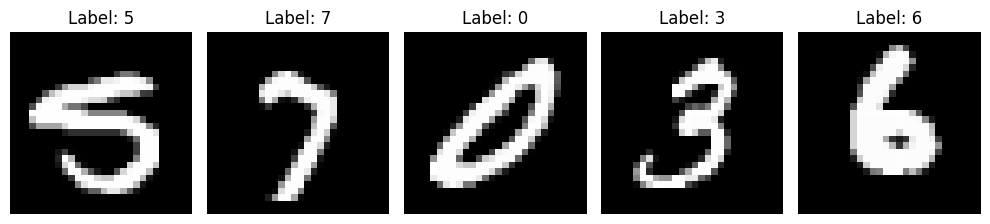

In [41]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# display 5 samples images
plt.figure(figsize=(10, 4))
for i in tqdm(range(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [49]:
images[0].numpy().squeeze().shape

(28, 28)

## Building a Neural Network

In [50]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()

        # Input image asre 28x28 pixels = 784 input features
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(28*28, 128) # 784 -> 128
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)   # 128 -> 64
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)    # 64 -> 10 (one for each digit 0-9)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]
        x = self.flatten(x)             # Flatten to [batch_size, 784]
        x = self.fc1(x)                # First fully connected layer
        x = self.relu1(x)             # Apply ReLU activation
        x = self.fc2(x)                # Second fully connected layer
        x = self.relu2(x)             # Apply ReLU activation
        x = self.fc3(x)                # Third fully connected layer
        return x
    
# Create the model
model = DigitRecognizer()
print(model)


DigitRecognizer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [53]:
# create dummpy data to test the model
dummy_data = torch.rand((1, 1, 28, 28))  # Batch size of 1, 1 channel, 28x28 image
dummy_output = model(dummy_data)
print("Dummy data shape: ", dummy_data.shape)  # Should be [1, 1, 28, 28]
# print("Dummy data: ", dummy_data)
print("Dummy output shape: ", dummy_output.shape)  # Should be [1, 10]
print("Dummy output: ", dummy_output)

Dummy data shape:  torch.Size([1, 1, 28, 28])
Dummy output shape:  torch.Size([1, 10])
Dummy output:  tensor([[ 0.0291,  0.1006, -0.0768,  0.1400, -0.0904,  0.0068, -0.1537,  0.2031,
         -0.0491, -0.0850]], grad_fn=<AddmmBackward0>)


## Define Loss Function and Optimizer

Before training, we need to define:

- A loss function to measure prediction errors
- An optimizer to update model weights



In [54]:
# Create entropy loss function is standard for classification tasks
criterion = nn.CrossEntropyLoss()

# Create optimizer : SGD optimizer with learning rate of 0.01 and momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


## Training the Model

In [58]:
num_epochs = 5

# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    for i, data in tqdm(enumerate(train_loader, 0)):
        # Get inputs and labels
        inputs, labels = data
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99: # Print every 100 mini-batches
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0


print('Finished Training')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Batch 100, Loss: 1.078


Epoch 1, Batch 200, Loss: 0.361


Epoch 1, Batch 300, Loss: 0.303


Epoch 1, Batch 400, Loss: 0.255


Epoch 1, Batch 500, Loss: 0.224


Epoch 1, Batch 600, Loss: 0.196


Epoch 1, Batch 700, Loss: 0.186


Epoch 1, Batch 800, Loss: 0.170


938it [00:03, 250.80it/s]
 20%|██        | 1/5 [00:03<00:15,  3.75s/it]

Epoch 1, Batch 900, Loss: 0.160


Epoch 2, Batch 100, Loss: 0.124


Epoch 2, Batch 200, Loss: 0.120


Epoch 2, Batch 300, Loss: 0.116


Epoch 2, Batch 400, Loss: 0.121


Epoch 2, Batch 500, Loss: 0.113


Epoch 2, Batch 600, Loss: 0.116


Epoch 2, Batch 700, Loss: 0.120


Epoch 2, Batch 800, Loss: 0.116


938it [00:03, 264.79it/s]
 40%|████      | 2/5 [00:07<00:10,  3.63s/it]

Epoch 2, Batch 900, Loss: 0.096


Epoch 3, Batch 100, Loss: 0.080


Epoch 3, Batch 200, Loss: 0.088


Epoch 3, Batch 300, Loss: 0.069


Epoch 3, Batch 400, Loss: 0.080


Epoch 3, Batch 500, Loss: 0.080


Epoch 3, Batch 600, Loss: 0.079


Epoch 3, Batch 700, Loss: 0.074


Epoch 3, Batch 800, Loss: 0.073


938it [00:03, 266.34it/s]
 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

Epoch 3, Batch 900, Loss: 0.078


Epoch 4, Batch 100, Loss: 0.055


Epoch 4, Batch 200, Loss: 0.059


Epoch 4, Batch 300, Loss: 0.061


Epoch 4, Batch 400, Loss: 0.062


Epoch 4, Batch 500, Loss: 0.065


Epoch 4, Batch 600, Loss: 0.056


Epoch 4, Batch 700, Loss: 0.060


Epoch 4, Batch 800, Loss: 0.060


938it [00:03, 269.07it/s]
 80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

Epoch 4, Batch 900, Loss: 0.064


Epoch 5, Batch 100, Loss: 0.044


Epoch 5, Batch 200, Loss: 0.034


Epoch 5, Batch 300, Loss: 0.048


Epoch 5, Batch 400, Loss: 0.048


Epoch 5, Batch 500, Loss: 0.043


Epoch 5, Batch 600, Loss: 0.042


Epoch 5, Batch 700, Loss: 0.045


Epoch 5, Batch 800, Loss: 0.046


938it [00:03, 271.82it/s]
100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

Epoch 5, Batch 900, Loss: 0.051
Finished Training


## Evaluating the Model


In [71]:
# Set model to evalutation mode
model.eval()

# Variables to track accuracy
correct = 0
total = 0

# No gradient compuatation needed for evaluation
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update statistics
        total += labels.size(0)
        correct += (predicted == labels ).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


100%|██████████| 157/157 [00:00<00:00, 217.25it/s]

Accuracy on the test set: 97.63%


In [72]:
# testing torch.max
ls = [1, 2, 3]
ls_tensor = torch.tensor(ls)
torch.max(ls_tensor)

tensor(3)

## Making Prediction on New Images

In [109]:
def preprocess_image(image_path):
    
    # Open and convert to grayscale
    image = Image.open(image_path).convert('L')
    
    # Resize to 28x28 pixels
    image = image.resize((28, 28))
    
    # Convert to tensor and normalize
    image_tensor = transforms.ToTensor()(image)
    image_tensor = transforms.Normalize((0.1307,), (0.3081,))(image_tensor)
    
    print(image_tensor.shape)  # Now prints: torch.Size([1, 1, 28, 28])
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    print(image_tensor.shape)  # Might print: torch.Size([1, 28, 28])
    
    return image_tensor


# Func to predict degit
def predict_digit(model, image_tensor):
    # Set model to evalation model
    model.eval()

    # Get the prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Example usage
image_tensor = preprocess_image('./digit-one.png')
result = predict_digit(model, image_tensor=image_tensor)
print(f'Predicted digit: {result}')

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
Predicted digit: 7


## Saving and Loading the Model

In [110]:
model_pth_path = 'digit_recognizer_v1.pth'

torch.save(model.state_dict(), model_pth_path)

loaded_model = DigitRecognizer()
loaded_model.load_state_dict(torch.load(model_pth_path))
loaded_model.eval()

DigitRecognizer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Checking model parameters

In [111]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params:,}')


# To see parameter sizes in each layer
for name, parameter in model.named_parameters():
    if parameter.requires_grad:
        print(f"{name}: {parameter.shape}, Parameters: {parameter.numel():,}")

Total trainable parameters: 109,386
fc1.weight: torch.Size([128, 784]), Parameters: 100,352
fc1.bias: torch.Size([128]), Parameters: 128
fc2.weight: torch.Size([64, 128]), Parameters: 8,192
fc2.bias: torch.Size([64]), Parameters: 64
fc3.weight: torch.Size([10, 64]), Parameters: 640
fc3.bias: torch.Size([10]), Parameters: 10


## Checking Model Precision

In [86]:
for name, param in model.named_parameters():
    print(f"{name}: {parameter.dtype}")

fc1.weight: torch.float32
fc1.bias: torch.float32
fc2.weight: torch.float32
fc2.bias: torch.float32
fc3.weight: torch.float32
fc3.bias: torch.float32


## Covert model to ONNX

In [120]:
model_onnx_path = model_pth_path.replace(".pth", ".onnx")

# First, create a dummy input tensor matching your expected input shape
# For MNIST, this would be a batch of images with shape [batch_size, channels, height, width]
dummy_input = torch.randn(1, 1, 28, 28)  # Batch size 1, 1 channel, 28x28 pixels


# Export the model
torch.onnx.export(
    model,
    dummy_input,
    model_onnx_path,
    opset_version=13,      # ONNX version
    do_constant_folding=True,  # Optimize constant folding
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'ouput': {0: 'batch_size'}
    }
)

print('Model exported to ONNX format!')

Model exported to ONNX format!


### Inference with ONNX Runtime

In [121]:
import onnxruntime as ort

# Create an ONNX Runtime session
session = ort.InferenceSession(model_onnx_path)

# Prepare input
input_name = session.get_inputs()[0].name
input_data = dummy_input.numpy()  # Convert tensor to numpy

# Run inference
outputs = session.run(None, {input_name: input_data})
predicted_class = outputs[0].argmax(axis=1)

print(f"Predicted class: {predicted_class[0]}")

Predicted class: 2


In [123]:
image_tensor = preprocess_image('./digit-8.png')
input_data = image_tensor.numpy()

outputs = session.run(None, {input_name: input_data})
predicted_class = outputs[0].argmax(axis=1)

print(f"Predicted class: {predicted_class[0]}")

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
Predicted class: 7


## Quantize model to half precision

In [102]:
import onnx
from onnxmltools.utils.float16_converter import convert_float_to_float16

onnx_model = onnx.load(model_onnx_path)

# Convert the ONNX model to FP16
onnx_fp16_path = model_onnx_path.replace(".onnx", "_fp16.onnx")
onnx_model_fp16 = convert_float_to_float16(onnx_model)

# Save the FP16 model
onnx.save(onnx_model_fp16, onnx_fp16_path)
print(f"Half precision model saved to: {onnx_fp16_path}")

# Verity the model
onnx.checker.check_model(onnx_model_fp16)
print("ONNX FP16 model is valid!")

Half precision model saved to: digit_recognizer_v1_fp16.onnx
ONNX FP16 model is valid!


In [108]:
import onnxruntime as ort

# Create an ONNX Runtime session
session = ort.InferenceSession(onnx_fp16_path)

# Prepare input
input_name = session.get_inputs()[0].name
image_tensor = preprocess_image('./digit-one.png')
image_tensor = image_tensor.half() # convert to half precision
image_array = image_tensor.numpy()

# Run inference
outputs = session.run(None, {input_name: image_array})
predicted_class = outputs[0].argmax(axis=1)

print(f"Predicted class: {predicted_class[0]}")

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
Predicted class: 7
